# DYNAMIC PRICING: INDITEX

### Autor: Lucía Saiz Lapique

### Examen Final: Análisis de Mercados y Tendencias



En el estudio a continuación se desean generar 3 estrategias de dynamic pricing, teniendo en cuenta los factores de demanda y oferta simulados para la situación actual (desescalada y nueva normalidad tras los dos meses de confinamiento en España por el Coronavirus). Para obtener los datos de precios y de demanda (carecemos de datos históricos reales) se realizarán dos estudios:
* __Forecasting:__ utilizando los datos de cotización de Inditex en el IBEX 35 durante el último año, se generarán una serie de predicciones que, más adelante, modificaremos para aplicar a las estrategias de cambio de precios
* __Web-scrapping:__ Obtener los precios de un mismo producto para tres marcas distintas de Inditex (Zara, Pull&Bear y Massimo Dutti).

In [1]:
## Importamos las librerias necesarias para el estudio a continuación
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import datetime
import os, time
import itertools
from time import time

from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats

import matplotlib
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.pylab import rcParams
rcParams['lines.linewidth'] = 2.5
rcParams['figure.figsize'] = 20, 10

import seaborn as sns
import yfinance as yf

import requests
from bs4 import BeautifulSoup
import re

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))

In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

## Forecasting

En primer lugar, con la librería de yahoo finance, obtenemos los datos de cierre en bolsa de los últimos 11 meses de la empresa Inditex.

In [3]:
tickerSymbol = 'ITX.MC'
tickerData = yf.Ticker(tickerSymbol)

In [4]:
datos = tickerData.history(period='1d', start='2019-7-1', end='2020-6-7')
datos.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-07-01,26.51,26.69,26.00,26.25,2634006,0.0,0
2019-07-02,26.25,26.38,26.12,26.33,2226758,0.0,0
2019-07-03,26.46,26.85,26.41,26.66,2792943,0.0,0
2019-07-04,26.69,26.93,26.69,26.87,1696621,0.0,0
2019-07-05,26.75,27.01,26.72,26.99,2896113,0.0,0


In [5]:
datos['Fecha'] = datos.index
datos['Fecha']

Date
2019-07-01   2019-07-01
2019-07-02   2019-07-02
2019-07-03   2019-07-03
2019-07-04   2019-07-04
2019-07-05   2019-07-05
                ...    
2020-06-01   2020-06-01
2020-06-02   2020-06-02
2020-06-03   2020-06-03
2020-06-04   2020-06-04
2020-06-05   2020-06-05
Name: Fecha, Length: 240, dtype: datetime64[ns]

A continuación, creamos una serie temporal con los datos de cierre obtenidos, guardándola en el objeto 'y', y comenzamos el análisis de la serie temporal para hacer las predicciones.

### Análisis de la serie temporal

In [6]:
y = \
(datos
 .loc[:, 'Close']
 .astype(float)
 .resample('D')
 .mean()
 .interpolate('time')
 .pipe(pd.Series, name='y')
)

y.index.name = 'Time'

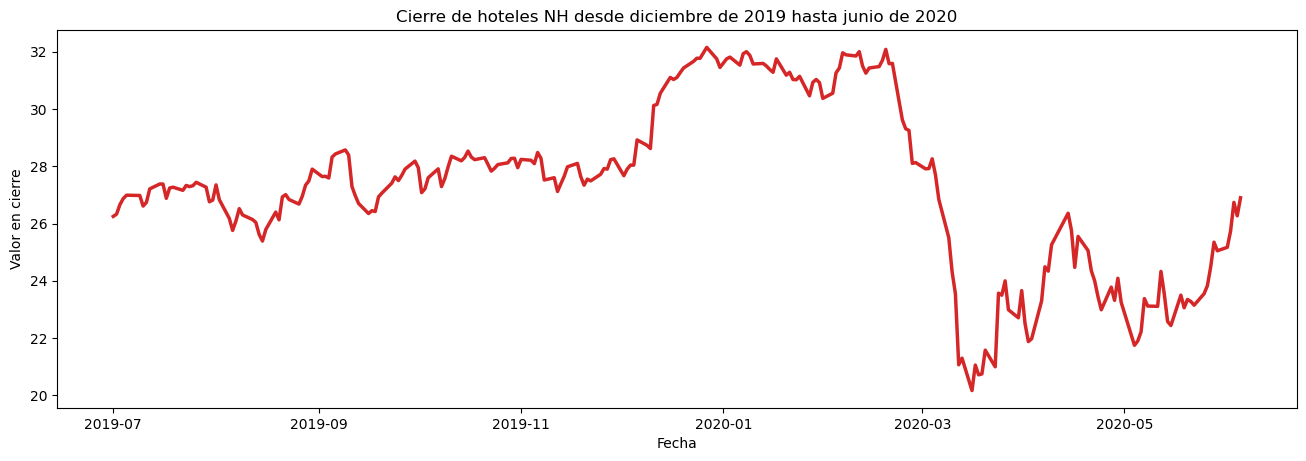

In [7]:
# Dibujamos el gráfico de la serie temporal
def plot_df(df, x, y, title = "", xlabel = 'Fecha', ylabel = 'Valor en cierre', dpi = 100):
    plt.figure(figsize=(16,5), dpi = dpi)
    plt.plot(x, y, color = 'tab:red')
    plt.gca().set(title = title, xlabel = xlabel, ylabel= ylabel)
    plt.show()

plot_df(y, x = y.index, y = y, 
        title='Cierre de hoteles NH desde diciembre de 2019 hasta junio de 2020')    

In [8]:
1 - y.min()/y.max()

0.3726283048211507

Como podemos observar, el valor de Inditex en bolsa ha llegado ha sufrir pérdidas de hasta un 37,26%, un valor muy similar al 44% que han disminuido las ventas de esta empresa en el primer trimestre del año. Asumimos que la tendencia del mercado de activos está directamente relacioando con la confianza de los clientes de realizar compras en una determinada tienda. una vez verificado esto, procedemos a generar las predicciones de la demana en base a un modelo SARIMA.

### Modelo SARIMA

In [9]:
y = pd.Series(datos.Close)

En primer lugar, se crean las funciones que utilizaremos a continuación, tanto pare seleccionar los hiperparámetros óptimos, como para ejecutar el modelo.

In [10]:
inicio = datetime.datetime.strptime('06/06/2020', '%d/%m/%Y')
dias = 70

dates = []
for days in range(dias):
    date = inicio + datetime.timedelta(days=days)
    if date.weekday() < 5:
        dates.append(date)

fechas_sarima = pd.to_datetime(dates, format="%d%m%Y")

In [11]:
df1 = pd.DataFrame(y)
df1['Fecha'] = df1.index
fs = pd.DataFrame(fechas_sarima)
df1 = pd.concat([df1.Fecha, fs], axis = 0)
df1 = df1.set_index(0)
df1['Close'] = y

In [12]:
## funcion para el grid search del modelo SARIMA
def run_sm_sarima(y=pd.Series(), ORDER=tuple(), fh=int()):
    """
    """
    y_tr = y
    y_te = fechas_sarima

    m = SARIMAX(y_tr, order=ORDER[0], seasonal_order=ORDER[1]).fit()
    yhat, ci = m.forecast(steps=fh), m.get_prediction(end=m.nobs + fh-1).conf_int()
    yhat.index = y_te
    ci = pd.DataFrame(ci)
    ci.index = df1.index 

    df = \
    pd.concat([
        pd.Series(yhat, index=y_te).to_frame('yhat'),
        pd.DataFrame(ci.loc[y_te, :].values, columns=['yhat_lower', 'yhat_upper'], index=y_te)], axis=1)

    return {'model': m,
           'order': ORDER,
           'model_aic': m.aic,
           'df': df}

C:\Users\Luli\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [13]:
##funcion para graficar la serie temporal con su prediccion
def visualize_forecasts(y=pd.Series(), df=pd.DataFrame(), fh=int()):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    y.to_frame(name='y').plot(ax=ax)
    ax_1 = df.plot(ax=ax, color=('r', 'k', 'k'), alpha=0.3)
    ax_1.fill_between(df.index, df['yhat_upper'], df['yhat_lower'], color='k', alpha=.2)

C:\Users\Luli\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


### Grid search SARIMA

El modelo de Grid Search nos permite que se seleccionen automáticamente los hiperparámetros óptimos para el cálculo de la demanda futura.

In [14]:
p = [1, 2]
q = [0, 1]
d = [1]
pdq = list(itertools.product(p, d, q))
PDQ = [tuple(list(x) + [7]) for x in pdq]
grid = list(itertools.product(pdq, PDQ))

In [15]:
list_gs = []
for pdqPDQ in grid[1:]:
    """
    """
    import warnings
    warnings.filterwarnings("ignore")
    
    result = run_sm_sarima(y = y.copy(), ORDER = pdqPDQ, fh = 50)
    try:
        list_gs.append(pd.Series({k:result.get(k) for k in ['order', 'model_aic', 'df']}))
    except:
        continue

In [16]:
df_order_select__SARIMA = pd.concat(list_gs, axis=1).T.set_index('order').round(2)
winner = df_order_select__SARIMA['model_aic'].map(np.float).idxmin()
print("The winning order is {}".format(winner))
df_predicted__SARIMA = df_order_select__SARIMA.loc[[winner], 'df'].iloc[0]

The winning order is ((1, 1, 1), (1, 1, 1, 7))


In [17]:
df_predicted__SARIMA.head(1)

,yhat,yhat_lower,yhat_upper
2020-06-08,27.264388,26.178599,28.350177


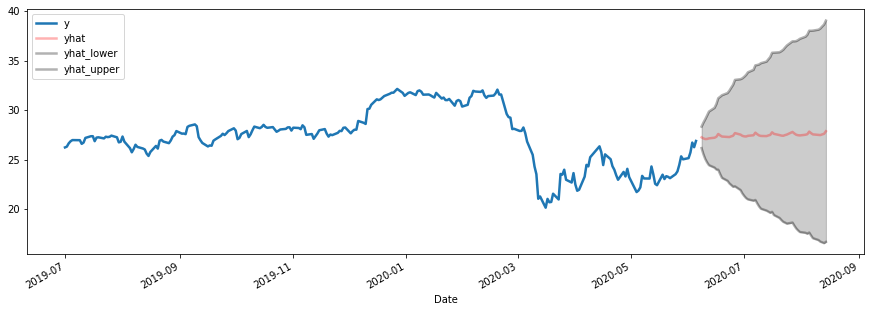

In [18]:
visualize_forecasts(y=y, df=df_predicted__SARIMA, fh=30)

In [19]:
demand = pd.concat([y, df_predicted__SARIMA.yhat])
demand.min(), demand.max()

(20.17, 32.15)

Como el cambio en la demanda es muy pequeño y necesitamos considerar una distancia mayor entre los valores paral as estrategias de dyanmic pricing, decidimos momdificar los datos para que se encuentren entre un rango de 10 a 90, en vez de de 20.17 a 32.15. 

In [20]:
df2 = pd.DataFrame(df_predicted__SARIMA.yhat)
demanda_final = (df2['yhat'] - 27)* 100

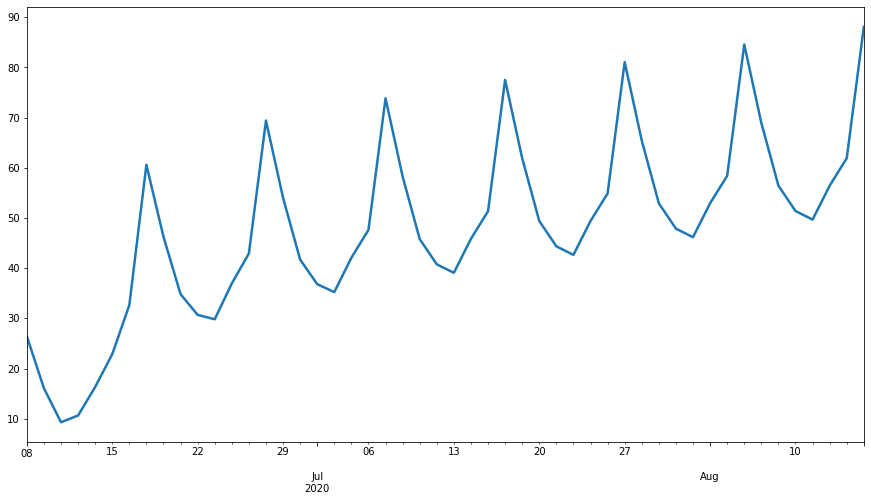

In [21]:
demanda_final.plot(figsize = (15,8))

En este gráfico podemos observar la demanda predicha. Una vez tenemos los datos de la demanda, podemos proceder a generar las estrategias de pricing. 

## Zara

### Web scrapping

Obtenemos los datos de precios de 50 blazers que ofrece Zara en su página web.

In [22]:
link = 'https://www.zara.com/es/es/mujer-blazers-l1055.html?v1=1445747'
link

'https://www.zara.com/es/es/mujer-blazers-l1055.html?v1=1445747'

In [23]:
response = requests.get(link)
soup = BeautifulSoup(response.text, "html.parser")

In [24]:
job_elems = soup.findAll('span', class_= "main-price")
job_elems = job_elems[:50]

In [25]:
paragraphs = []
for x in job_elems:
    paragraphs.append(str(x))

In [26]:
lista = []
for i in paragraphs:
    j = re.findall('\d+', i)
    lista.append(j)

In [27]:
zara = []
for i in lista:
    z = i[0] + '.' + i[1]
    z = float(z)
    zara.append(z)

### Dynamic Pricing Strategy

El __objetivo__ del siguiente análisis es encontrar la distribución óptima de precios (con una serie de probabilidades generadas en base a los precios inputados), teniendo en cuuenta tres factores: histórico de datos de precios de una prenda común para las tres marcas, demanda esperada y el inventario (número de unidades) que la empresa en cuestión tiene disponible.  
A continuación se genera una serie de funciones que utilizaremos en las tres estrategias para las tres marcas seleccionadas para generar las distribuciones de precio óptimas.

In [28]:
def optimal_price_probabilities(prices, demands, inventory):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [29]:
prices = list(zara)
demands = list(demanda_final.round(2))
revenues = np.multiply(prices, demands)
print(prices)
print(demands)
print(revenues)
print(optimal_price_probabilities(prices, demands, 100)) ## comprobamos que funciona la función para generar las probabildiades

[59.95, 49.95, 49.95, 49.95, 39.95, 89.95, 39.95, 29.95, 29.95, 49.95, 29.95, 49.95, 39.95, 39.95, 49.95, 39.95, 39.95, 39.95, 59.95, 49.95, 49.95, 39.95, 49.95, 69.95, 49.95, 89.95, 69.95, 89.95, 59.95, 89.95, 49.95, 39.95, 29.95, 49.95, 49.95, 49.95, 59.95, 59.95, 79.95, 69.95, 39.95, 39.95, 49.95, 29.95, 29.95, 29.95, 69.95, 39.95, 39.95, 59.95]
[26.44, 16.1, 9.31, 10.66, 16.32, 22.87, 32.64, 60.6, 46.26, 34.83, 30.71, 29.83, 36.96, 42.93, 69.41, 54.03, 41.72, 36.82, 35.24, 42.08, 47.63, 73.85, 58.27, 45.8, 40.78, 39.09, 45.86, 51.35, 77.52, 61.91, 49.41, 44.36, 42.66, 49.42, 54.89, 81.06, 65.44, 52.93, 47.89, 46.18, 52.93, 58.4, 84.57, 68.95, 56.44, 51.39, 49.69, 56.44, 61.91, 88.08]
[1585.08  804.2   465.03  532.47  651.98 2057.16 1303.97 1814.97 1385.49
 1739.76  919.76 1490.01 1476.55 1715.05 3467.03 2158.5  1666.71 1470.96
 2112.64 2101.9  2379.12 2950.31 2910.59 3203.71 2036.96 3516.15 3207.91
 4618.93 4647.32 5568.8  2468.03 1772.18 1277.67 2468.53 2741.76 4048.95
 3923.13 31

In [30]:
# Se asume una distribución lienal de la demanda, seleccionando el valor máximo de la demanda y el mínimo
demand_a = max(demands)
demand_b = min(demands)

# Averiguamos los parámetros de la distribución Gamma que componen los datos de los precios
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 8.588, 'beta': 0.1674, 'mean': np.mean(prices)})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = (demand_a - demand_b) * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))

In [31]:
T = 50 
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 100.0) ## seleccionamos un inventario de 100, teniendo en cuenta 
    # que la máxima demanda que hemos predicho es 90, para satisfacer la demanda pero mostrando que ha disminuido
    
    # selecciona el mejor precio para las probabilidades calculadas
    price_index_t = np.random.choice(len(prices), 1, p = price_probs)[0]
    price_t = prices[price_index_t]
    
    # simulamos la venta del producto con ese precio para estimar cual será el beneficio
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # Actualizamos los parámetros del modelo
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒═══════╤═══════╤════════╤═══════╕
│ 59.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 49.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 49.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 49.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 39.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 89.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 39.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 29.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 29.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 49.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 29.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 49.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 39.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼────────┼───────┤
│ 39.95 │ 8.588 │ 0.1674 │ 51.15 │
├───────┼───────┼───

╘═══════╧══════════╧════════╧═════════╛
demands =  [  80.63   36.04   45.4    86.59   52.99 6041.77   82.21   65.94   47.56
   77.36   33.86   90.26   30.57   26.48   57.02   56.16   58.65   37.
   44.79   46.33   47.25   37.81   49.3    61.36   47.68   35.57   29.61
 5988.55   57.61   51.61   57.09   49.79   57.28   88.12   56.57   38.94
   53.35   40.1    45.15   51.16   49.68   40.2    39.93   88.02   73.56
   26.25   68.14   35.13   64.15   81.05]
selected price 89.95 => demand 7122.00, revenue 640623.90

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├────

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤


selected price 69.95 => demand 5473.00, revenue 382836.35

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 

selected price 39.95 => demand 3165.00, revenue 126441.75

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 

selected price 49.95 => demand 3951.00, revenue 197352.45

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 

selected price 59.95 => demand 4788.00, revenue 287040.60

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 

selected price 49.95 => demand 3847.00, revenue 192157.65

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

selected price 49.95 => demand 3989.00, revenue 199250.55

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 1.1674 │ 3392.66 │
├───────┼──────────┼────────┼─────────┤


╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 1.1674 │ 3392.66 │
├───────┼──────────┼────────┼─────────┤


selected price 49.95 => demand 3868.00, revenue 193206.60

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

selected price 49.95 => demand 3933.00, revenue 196453.35

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2341.59  │ 1.1674 │ 2005.81 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

╘═══════╧══════════╧════════╧═════════╛
demands =  [3975.34   32.09 3387.43 3394.06   36.35 6217.35 2560.7    51.73   32.13
 3288.11 1989.99 3270.65 2653.58   39.02 3345.52 2678.84   40.6    40.53
 4140.9  3258.23 3363.54   63.68 3317.8  5016.41 3331.79 6067.25 4657.09
 6086.29 4091.46 5918.49   48.11   47.49   66.99 3398.76   27.83 3277.37
 3945.49 3935.39 5314.82 4794.91   72.27   53.8  3438.91   57.48   26.72
   64.71 4807.59   55.9    38.05 4051.55]
selected price 49.95 => demand 3875.00, revenue 193556.25

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├──

╘═══════╧══════════╧════════╧═════════╛
demands =  [4044.42   47.94 3371.44 3367.8    43.23 6147.52 2580.31   65.51   81.75
 3417.6  1988.31 3316.61 2689.14   53.9  3198.82 2804.16   22.62   84.68
 4104.21 3381.01 3339.96   39.42 3288.22 4770.61 3311.17 6069.94 4674.05
 6080.66 3940.3  6043.39   22.83   40.54   62.28 3304.93 3336.28 3329.63
 4077.55 3987.11 5283.3  4564.3    57.73 2674.15 3319.3    50.24   57.91
   56.4  4960.45   36.65   45.63 4141.52]
selected price 49.95 => demand 3893.00, revenue 194455.35

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├──

╘═══════╧══════════╧════════╧═════════╛
demands =  [4051.85   51.51 3338.46 3403.32   66.85 6042.35 2535.87   81.53   89.15
 3408.51 2029.93 3389.24 2651.42 2638.77 3280.81 2801.99   69.87   51.52
 4118.86 3305.85 3312.8    40.11 3392.46 4677.98 3466.19 6220.67 4573.72
 5992.83 3979.34 6183.79 3491.21   43.02   66.24 3283.73 3243.4  3310.62
 4098.47 4009.75 5243.45 4714.67   71.11 2749.99 3370.34   52.98   47.89
   24.8  4687.31   40.49   36.15 4072.73]
selected price 29.95 => demand 2280.00, revenue 68286.00

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───

╘═══════╧══════════╧════════╧═════════╛
demands =  [4055.4    80.07 3433.16 3500.22   35.16 6184.04 2553.75   41.55 2044.84
 3337.92 1943.59 3419.5  2639.74 2736.76 3318.28 2818.54   27.85   51.17
 4065.42 3320.77 3228.57   62.65 3267.4  4901.99 3480.53 6096.16 4633.79
 6112.23 4083.31 6057.24 3383.11   37.35   55.67 3352.39 3246.95 3322.07
 4032.8  4010.06 5297.73 4671.73   86.61 2746.56 3300.38   21.55   38.44
 1878.21 4855.12   58.27   23.26 4000.33]
selected price 39.95 => demand 3181.00, revenue 127080.95

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├──

selected price 39.95 => demand 3180.00, revenue 127041.00

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2431.59  │ 1.1674 │ 2082.91 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2394.59  │ 1.1674 │ 2051.21 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2341.59  │ 1.1674 │ 2005.81 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2431.59  │ 1.1674 │ 2082.91 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2394.59  │ 1.1674 │ 2051.21 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2341.59  │ 1.1674 │ 2005.81 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 1.1674 │ 3392.66 │
├───────┼──────────┼────────┼─────────┤


 1947.4  4668.17 2818.46 2768.2  4179.63]
selected price 39.95 => demand 3115.00, revenue 124444.25

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2431.59  │ 1.1674 │ 2082.91 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2394.59  │ 1.1674 │ 2051.21 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2341.59  │ 1.1674 │ 2005.81 │
├───────┼──────────

selected price 49.95 => demand 3864.00, revenue 193006.80

╒═══════╤══════════╤════════╤═════════╕
│ 59.95 │ 4720.59  │ 1.1674 │ 4043.68 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3872.59  │ 1.1674 │ 3317.28 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3990.59  │ 1.1674 │ 3418.36 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3997.59  │ 1.1674 │ 3424.35 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │    8.588 │ 0.1674 │   51.15 │
├───────┼──────────┼────────┼─────────┤
│ 89.95 │ 7107.59  │ 1.1674 │ 6088.39 │
├───────┼──────────┼────────┼─────────┤
│ 39.95 │ 2974.59  │ 1.1674 │ 2548.05 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2431.59  │ 1.1674 │ 2082.91 │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2394.59  │ 1.1674 │ 2051.21 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3959.59  │ 1.1674 │ 3391.8  │
├───────┼──────────┼────────┼─────────┤
│ 29.95 │ 2341.59  │ 1.1674 │ 2005.81 │
├───────┼──────────┼────────┼─────────┤
│ 49.95 │ 3960.59  │ 

selected price 89.95 => demand 6950.00, revenue 625152.50

╒═══════╤═══════════╤════════╤═════════╕
│ 59.95 │  4720.59  │ 1.1674 │ 4043.68 │
├───────┼───────────┼────────┼─────────┤
│ 49.95 │  3872.59  │ 1.1674 │ 3317.28 │
├───────┼───────────┼────────┼─────────┤
│ 49.95 │  3990.59  │ 1.1674 │ 3418.36 │
├───────┼───────────┼────────┼─────────┤
│ 49.95 │  3997.59  │ 1.1674 │ 3424.35 │
├───────┼───────────┼────────┼─────────┤
│ 39.95 │  3191.59  │ 1.1674 │ 2733.93 │
├───────┼───────────┼────────┼─────────┤
│ 89.95 │  7107.59  │ 1.1674 │ 6088.39 │
├───────┼───────────┼────────┼─────────┤
│ 39.95 │  2974.59  │ 1.1674 │ 2548.05 │
├───────┼───────────┼────────┼─────────┤
│ 29.95 │  2431.59  │ 1.1674 │ 2082.91 │
├───────┼───────────┼────────┼─────────┤
│ 29.95 │  2394.59  │ 1.1674 │ 2051.21 │
├───────┼───────────┼────────┼─────────┤
│ 49.95 │  3959.59  │ 1.1674 │ 3391.8  │
├───────┼───────────┼────────┼─────────┤
│ 29.95 │  2341.59  │ 1.1674 │ 2005.81 │
├───────┼───────────┼────────┼─────────

In [32]:
precios = []
beneficios = []
demandas = []
for i in history:
    precio = round(i[0], 2)
    demanda = i[1]
    beneficio = round(i[2], 2)
    precios.append(precio)
    demandas.append(demanda)
    beneficios.append(beneficio)

In [33]:
final = pd.DataFrame(list(zip(precios, beneficios, demandas)), columns = ['Precios', 'Beneficios', 'Demanda'])

In [34]:
final

,Precios,Beneficios,Demanda
0,89.95,638555.05,7099
1,89.95,632618.35,7033
2,89.95,640623.90,7122
3,89.95,637385.70,7086
4,79.95,495769.95,6201
5,59.95,282484.40,4712
6,69.95,382836.35,5473
7,59.95,283323.70,4726
8,69.95,384515.15,5497
9,39.95,126441.75,3165


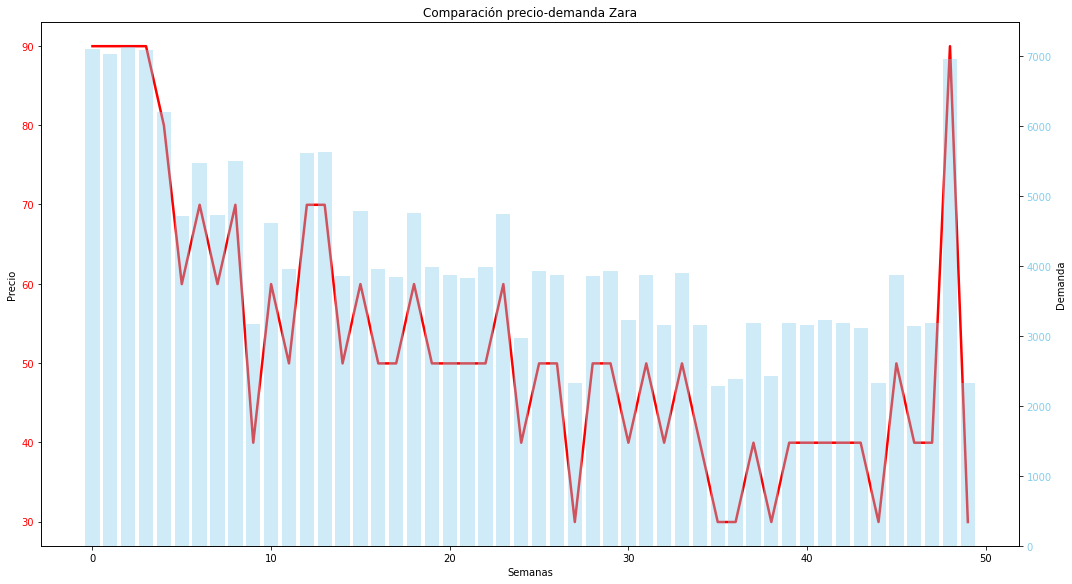

In [35]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Semanas')
ax1.set_ylabel('Precio', color='black')
ax1.plot(final.Precios, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  

ax2.set_ylabel('Demanda', color='black')
ax2.bar(final.index, final.Demanda, color='skyblue', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='skyblue')

fig.tight_layout()  
plt.title('Comparación precio-demanda Zara')
plt.show()

Podemos observar en el gráfico anterior que los precios calculados van descendiendo ligeramente de la misma forma que lo hace la demanda simulada. A continuación se genera este mismo estudio con las otras dos empresas (low cost y high cost) para ver como varía este resultado, pero aplicando la misma estrategia. 

## Pull&Bear

### Web-scrapping

Debido a una serie de problemas en la página web, no se ha podido hacer web-scrapping de esta marca (ni de Massimo Dutti), por un problema de acceso probablemente debido a las cookies de la página o su parametrización a la hora de recopilar datos. Por ello, en esta estrategia y en la siguiente, se han introducido los datos de las blazers de cada marca a mano.

In [36]:
prices2 = [25.99, 29.99, 35.99, 35.99, 35.99, 29.99, 25.99, 25.99, 25.99, 25.99, 35.99, 35.99, 35.99, 25.99, 35.99, 29.99,
          29.99, 25.99, 25.99, 25.99, 35.99, 35.99, 25.99, 35.99, 29.99, 25.99, 29.99, 35.99, 35.99, 35.99, 29.99, 25.99, 
           25.99, 25.99, 25.99, 35.99, 35.99, 35.99, 25.99, 35.99, 29.99, 29.99, 25.99, 25.99, 25.99, 35.99, 35.99, 25.99, 
           35.99, 29.99]
len(prices2)

50

### Dynamic Pricing

In [37]:
# Optimization procedure test
demands2 = list(demanda_final.round(2))
revenues2 = np.multiply(prices2, demands2)
print(demands2)
print(revenues2)
print(optimal_price_probabilities(prices2, demands2, 100))

[26.44, 16.1, 9.31, 10.66, 16.32, 22.87, 32.64, 60.6, 46.26, 34.83, 30.71, 29.83, 36.96, 42.93, 69.41, 54.03, 41.72, 36.82, 35.24, 42.08, 47.63, 73.85, 58.27, 45.8, 40.78, 39.09, 45.86, 51.35, 77.52, 61.91, 49.41, 44.36, 42.66, 49.42, 54.89, 81.06, 65.44, 52.93, 47.89, 46.18, 52.93, 58.4, 84.57, 68.95, 56.44, 51.39, 49.69, 56.44, 61.91, 88.08]
[ 687.18  482.84  335.07  383.65  587.36  685.87  848.31 1574.99 1202.3
  905.23 1105.25 1073.58 1330.19 1115.75 2498.07 1620.36 1251.18  956.95
  915.89 1093.66 1714.2  2657.86 1514.44 1648.34 1222.99 1015.95 1375.34
 1848.09 2789.94 2228.14 1481.81 1152.92 1108.73 1284.43 1426.59 2917.35
 2355.19 1904.95 1244.66 1662.02 1587.37 1751.42 2197.97 1792.01 1466.88
 1849.53 1788.34 1466.88 2228.14 2641.52]
[1.15e-12 1.06e-12 1.01e-12 1.03e-12 1.11e-12 1.15e-12 1.22e-12 1.77e-12
 1.44e-12 1.25e-12 1.41e-12 1.39e-12 1.59e-12 1.38e-12 4.56e-12 1.86e-12
 1.50e-12 1.28e-12 1.26e-12 1.37e-12 2.03e-12 6.46e-12 1.71e-12 1.94e-12
 1.48e-12 1.32e-12 1.60e-12 2

In [38]:
demand_a = max(demands2)
demand_b = min(demands2)

θ = []
for p in prices2:
    θ.append({'price': p, 'alpha':26.69, 'beta': 0.8638, 'mean': np.mean(prices2)})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = (demand_a - demand_b) * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))

In [39]:
T = 50
history2 = []
for t in range(0, T):              # simulation loop
    demands2 = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands2))
    
    price_probs = optimal_price_probabilities(prices2, demands2, 100.0) 
    
    # se selecciona el mejor precio
    price_index_t = np.random.choice(len(prices2), 1, p = price_probs)[0]
    price_t = prices2[price_index_t]
    
    # se simula la venta del producto con dichos precios para simular los beneficios
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history2.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # actualizamos los parámetros del modelo
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒═══════╤═══════╤════════╤═══════╕
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 29.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 29.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 35.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼────────┼───────┤
│ 25.99 │ 26.69 │ 0.8638 │ 30.79 │
├───────┼───────┼───

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.863

selected price 35.99 => demand 2680.00, revenue 96453.20

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │   26.69 │ 0.8638 │   30.79 │
├─────

selected price 35.99 => demand 2795.00, revenue 100592.05

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├────

selected price 29.99 => demand 2387.00, revenue 71586.13

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├─────

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2298.69 │ 1.8638 │ 1233.34 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2706.69 │ 1.863

selected price 25.99 => demand 2080.00, revenue 54059.20

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2298.69 │ 1.8638 │ 1233.34 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2390.69 │ 1.8638 │ 1282.7  │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├─────

╘═══════╧═════════╧════════╧═════════╛
demands =  [  28.87 1251.91 1524.86 1494.98 1442.36 1344.39   31.16   26.66 1115.93
   26.57 1604.09 1539.81 1955.7  1100.9  1543.56 1231.07 1302.48 1135.8
   45.8    26.89 1585.01 1481.58 1125.44 1544.25 1262.9    34.11 1301.05
 1501.41 1494.72 1534.29 1285.8    32.97 1132.69   29.97   34.21 1556.17
 1528.05 1990.33 1133.63 1527.51 1332.36 1344.36   29.89   38.67 1058.35
 1540.2  1542.8    27.99 1508.76 1238.4 ]
selected price 25.99 => demand 2152.00, revenue 55930.48

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │   26.69 │ 0.8638 │   30.79 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2298.69 │ 1.8638 │ 1233.34 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2390.69 │ 1.8638 │ 1282.7  │
├───────┼─────────

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │ 2060.69 │ 1.8638 │ 1105.64 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2298.69 │ 1.8638 │ 1233.34 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2390.69 │ 1.8638 │ 1282.7  │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2036.69 │ 1.8638 │ 1092.76 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2000.69 │ 1.8638 │ 1073.45 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2051.69 │ 1.8638 │ 1100.81 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2178.69 │ 1.8638 │ 1168.95 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 5580.69 │ 2.863

selected price 25.99 => demand 2027.00, revenue 52681.73

╒═══════╤═════════╤════════╤═════════╕
│ 25.99 │ 2060.69 │ 1.8638 │ 1105.64 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2298.69 │ 1.8638 │ 1233.34 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2860.69 │ 1.8638 │ 1534.87 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2875.69 │ 1.8638 │ 1542.92 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2808.69 │ 1.8638 │ 1506.97 │
├───────┼─────────┼────────┼─────────┤
│ 29.99 │ 2390.69 │ 1.8638 │ 1282.7  │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2036.69 │ 1.8638 │ 1092.76 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2000.69 │ 1.8638 │ 1073.45 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2051.69 │ 1.8638 │ 1100.81 │
├───────┼─────────┼────────┼─────────┤
│ 25.99 │ 2178.69 │ 1.8638 │ 1168.95 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2849.69 │ 1.8638 │ 1528.97 │
├───────┼─────────┼────────┼─────────┤
│ 35.99 │ 2800.69 │ 1.8638 │ 1502.68 │
├─────

In [40]:
precios2 = []
beneficios2 = []
demandas2 = []
for i in history2:
    precio2 = round(i[0], 2)
    demanda2 = i[1]
    beneficio2 = round(i[2], 2)
    precios2.append(precio2)
    demandas2.append(demanda2)
    beneficios2.append(beneficio2)

In [41]:
final = pd.DataFrame(list(zip(precios2, beneficios2, demandas2)), columns = ['Precios', 'Beneficios', 'Demanda'])

In [42]:
final

,Precios,Beneficios,Demanda
0,35.99,100520.07,2793
1,35.99,100124.18,2782
2,35.99,103507.24,2876
3,35.99,99404.38,2762
4,35.99,101995.66,2834
5,35.99,101959.67,2833
6,35.99,101599.77,2823
7,35.99,103147.34,2866
8,35.99,101887.69,2831
9,35.99,102211.60,2840


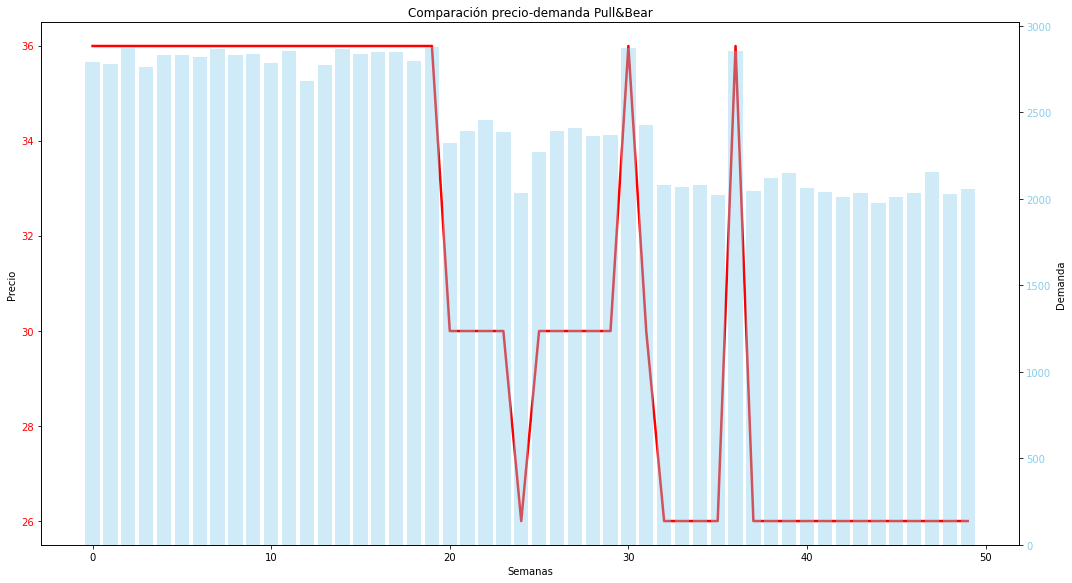

In [43]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Semanas')
ax1.set_ylabel('Precio', color='black')
ax1.plot(final.Precios, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Demanda', color='black')
ax2.bar(final.index, final.Demanda, color='skyblue', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='skyblue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparación precio-demanda Pull&Bear')
plt.show()

Se pueden sacar varias conclusiones del caso low-cost que hemos analizado:
* El rango de precios es muy pequeño (solo 10€ de diferencia entre el máximo y el mínimo)
* Los precios bajan con la misma tendencia con la que disminuye la demanda simulada
* Hay solo 3 precios óptimos generados, no hay mucha variedad, probablemente porque los precios imputados originales eran muy similares entre ellos

## Massimo Dutti

### Web-Scrapping

In [44]:
prices3 = [129.00, 99.95, 129.00, 99.95, 99.95, 129.00, 129.00, 89.95, 149.00, 169.00, 169.00, 169.00, 129.00, 169.00,
          169.00, 129.00, 99.95, 59.95, 129.00, 129.00, 99.95, 99.95, 99.95, 129.00, 129.00, 149.00, 99.95, 69.95, 129.00,
          79.95, 249.00, 149.00, 59.95, 129.00, 129.00, 149.00, 79.95, 99.95,149.00, 69.95, 129.00, 99.95, 129.00, 99.95, 
           99.95, 129.00, 129.00, 89.95, 149.00, 169.00]
len(prices3)

50

### Dynamic Pricing

In [45]:
# Optimization procedure test
demands3 = list(demanda_final.round(2))
revenues3 = np.multiply(prices3, demands3)
print(demands3)
print(revenues3)
print(optimal_price_probabilities(prices3, demands3, 100))

[26.44, 16.1, 9.31, 10.66, 16.32, 22.87, 32.64, 60.6, 46.26, 34.83, 30.71, 29.83, 36.96, 42.93, 69.41, 54.03, 41.72, 36.82, 35.24, 42.08, 47.63, 73.85, 58.27, 45.8, 40.78, 39.09, 45.86, 51.35, 77.52, 61.91, 49.41, 44.36, 42.66, 49.42, 54.89, 81.06, 65.44, 52.93, 47.89, 46.18, 52.93, 58.4, 84.57, 68.95, 56.44, 51.39, 49.69, 56.44, 61.91, 88.08]
[ 3410.76  1609.2   1200.99  1065.47  1631.18  2950.23  4210.56  5450.97
  6892.74  5886.27  5189.99  5041.27  4767.84  7255.17 11730.29  6969.87
  4169.91  2207.36  4545.96  5428.32  4760.62  7381.31  5824.09  5908.2
  5260.62  5824.41  4583.71  3591.93 10000.08  4949.7  12303.09  6609.64
  2557.47  6375.18  7080.81 12077.94  5231.93  5290.35  7135.61  3230.29
  6827.97  5837.08 10909.53  6891.55  5641.18  6629.31  6410.01  5076.78
  9224.59 14885.52]
[1.54e-13 1.21e-13 1.25e-13 1.18e-13 1.21e-13 1.47e-13 1.67e-13 1.64e-13
 2.62e-13 2.63e-13 2.34e-13 2.29e-13 1.78e-13 3.33e-13 8.95e-13 2.33e-13
 1.51e-13 1.17e-13 1.73e-13 1.92e-13 1.61e-13 2.02e

In [46]:
demand_a = max(demands3)
demand_b = min(demands3)

θ = []
for p in prices3:
    θ.append({'price': p, 'alpha': 12.27, 'beta': 0.0988, 'mean': np.mean(prices3)})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = (demand_a - demand_b) * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))

In [47]:
T = 50
history3 = []
for t in range(0, T):              # simulation loop
    demands3 = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands3))
    
    price_probs = optimal_price_probabilities(prices3, demands3, 150.0) 
    
    # seleccionamos el mejor precio
    price_index_t = np.random.choice(len(prices3), 1, p = price_probs)[0]
    price_t = prices3[price_index_t]
    
    # se simulan ventas para calcular los beneficios
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history3.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # actualizamos los parámetros del modelo
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒════════╤═══════╤════════╤════════╕
│ 129    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│  99.95 │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 129    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│  99.95 │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│  99.95 │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 129    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 129    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│  89.95 │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 149    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 169    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 169    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 169    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│ 129    │ 12.27 │ 0.0988 │ 122.98 │
├────────┼───────┼────────┼────────┤
│

selected price 149.00 => demand 11782.00, revenue 1755518.00

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼────

selected price 149.00 => demand 11763.00, revenue 1752687.00

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼────

selected price 149.00 => demand 11857.00, revenue 1766693.00

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼────

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

selected price 129.00 => demand 10389.00, revenue 1340181.00

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼────

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

selected price 99.95 => demand 7831.00, revenue 782708.45

╒════════╤══════════╤════════╤══════════╕
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼───────

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

selected price 79.95 => demand 6428.00, revenue 513918.60

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼───────

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7874.27 │ 1.0988 │  7166.24 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7839.27 │ 1.0988 │  7134.39 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7874.27 │ 1.0988 │  7166.24 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7839.27 │ 1.0988 │  7134.39 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7874.27 │ 1.0988 │  7166.24 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

selected price 69.95 => demand 5395.00, revenue 377380.25

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7839.27 │ 1.0988 │  7134.39 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7874.27 │ 1.0988 │  7166.24 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10184.3  │ 1.0988 │  9268.54 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │    12.27 │ 0.0988 │   122.98 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼───────

╒════════╤══════════╤════════╤══════════╕
│ 129    │ 10107.3  │ 1.0988 │  9198.46 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7886.27 │ 1.0988 │  7177.17 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10165.3  │ 1.0988 │  9251.25 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7839.27 │ 1.0988 │  7134.39 │
├────────┼──────────┼────────┼──────────┤
│  99.95 │  7874.27 │ 1.0988 │  7166.24 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10130.3  │ 1.0988 │  9219.39 │
├────────┼──────────┼────────┼──────────┤
│ 129    │ 10184.3  │ 1.0988 │  9268.54 │
├────────┼──────────┼────────┼──────────┤
│  89.95 │  7009.27 │ 1.0988 │  6379.02 │
├────────┼──────────┼────────┼──────────┤
│ 149    │ 11877.3  │ 1.0988 │ 10809.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13447.3  │ 1.0988 │ 12238.1  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13190.3  │ 1.0988 │ 12004.3  │
├────────┼──────────┼────────┼──────────┤
│ 169    │ 13494.3  │ 1.0988 │ 122

In [48]:
precios3 = []
beneficios3 = []
demandas3 = []
for i in history3:
    precio3 = round(i[0], 2)
    demanda3 = i[1]
    beneficio3 = round(i[2], 2)
    precios3.append(precio3)
    demandas3.append(demanda3)
    beneficios3.append(beneficio3)

In [49]:
final = pd.DataFrame(list(zip(precios3, beneficios3, demandas3)), columns = ['Precios', 'Beneficios', 'Demanda'])

In [50]:
final

,Precios,Beneficios,Demanda
0,249.00,4867701.00,19549
1,149.00,1755518.00,11782
2,169.00,2278458.00,13482
3,169.00,2257502.00,13358
4,149.00,1752687.00,11763
5,169.00,2243137.00,13273
6,149.00,1766693.00,11857
7,129.00,1310382.00,10158
8,169.00,2270515.00,13435
9,129.00,1317864.00,10216


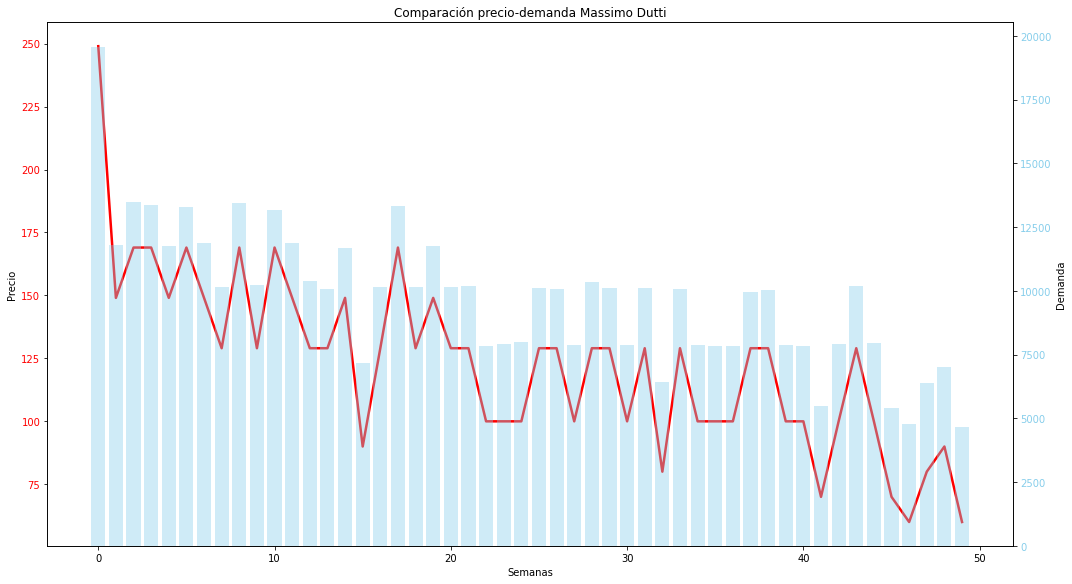

In [51]:
fig, ax1 = plt.subplots(figsize=(15,8))

ax1.set_xlabel('Semanas')
ax1.set_ylabel('Precio', color='black')
ax1.plot(final.Precios, color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Demanda', color='black')
ax2.bar(final.index, final.Demanda, color='skyblue', alpha = 0.4)
ax2.tick_params(axis='y', labelcolor='skyblue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Comparación precio-demanda Massimo Dutti')
plt.show()

De Massimo Dutti observamos que existe una caída muy pronunciada (la que más) con precios muy variados en un rango muy amplio (el máximo precio óptimo es de 250€ mientras que el mínimo es 60€). Los precios siguen, igual que las otras dos estrategias, la misma tendencia que la demanda. 

## Recomendaciones:

Este estudio, para aplicarlo a la empresa en la vida real, se tendría que realizar con los datos históricos reales de muchas prendas distintas y de todas las marcas que componen a Inditex. Además, se tendrían que predecir los datos de demanda en base a la demanda real de los últimos meses, no únicamente con los datos de bolsa (aunque considero que también se deberían tener en cuenta para el cálculo). Por último, los datos de inventario también se podrían obtener desde dentro de la empresa. 

Este estudio es tan solo un ejemplo, para generarlo de forma seria se deberían crear una serie de modelos (no solo usar funciones) que se puedan entrenar con datos históricos y que así la distribución de precios óptimoss generados sea más ajustada a la realidad. 

__Bibliografía:__
* https://www.zara.com/es/
* https://www.massimodutti.com/es/
* https://www.pullandbear.com/es/
* https://github.com/ikatsov/tensor-house
* https://blog.griddynamics.com/dynamic-pricing-algorithms/
* https://github.com/dushyantkhosla/ts-forecasting-ensemble/blob/master/notebooks/04-predict-with-sarimax.ipynb